In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

The SVM model used in this project is a linear-kernel based binary classifier model which utilizes the Sequential Minimal Optimization Model for the task of finding the support vectors that characterize the model. The algorithm of SMO used here is as described by John Platt in 1998 [PDF]

## SVM Overview

The main essence of classifying data using SVM is to define a hyperplane in the feature space that divides the data with positive label from the data with negative label.
Mathematically, the equation for the hyperplane is given as:
    
 
 


The label of a datapoint is then decided by the hyperplane as:

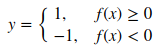



This, however is similar to a Logistic Regression model. The peculiarity and importance of SVM lies in the type of hyperplane that is selected as the divider. Instead of selecting any hyperplane, SVM chooses the hyperplane that maximizes the margin between the two classes. Through an involved derivation process, it can be shown that the margin is inversely proportional to the norm of the feature vector (w). Hence the optimization can be formulated as minimization over w as follows:
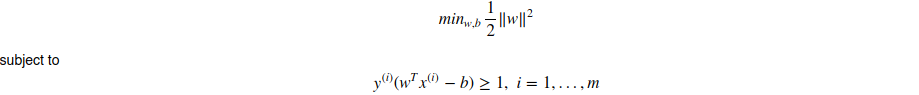

## Constraint Optimization Problem

The above equation shows that SVM is a constraint optimization problem which is easier to solve by the use of Lagrangian Multipliers and reformulation into a dual form

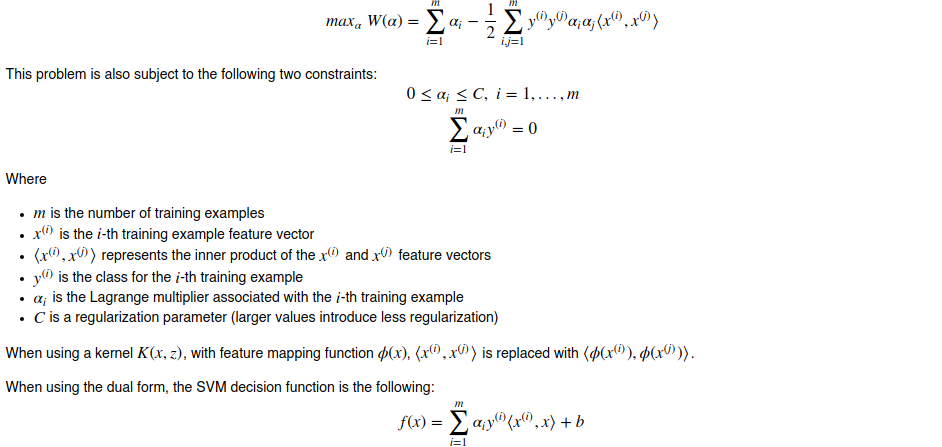

## The SMO Algorithm

SMO works by breaking the dual form into many smaller optimization problems which can be solved easily.
The algorithm works as follows:

--Two multiplier values ( αi  and  αj ) are selected out and their values are optimized while holding all other  α  values constant.

--Once these two are optimized, another two are chosen and optimized over.

--Choosing and optimizing repeats until the convergence, which is determined based on the problem constraints. Heuristics can be used to select the two  α  values to optimize over.

## Expected outcome of the algorithm
The output of the algorithm is a vector of  α  values that are mostly zeros, except where the corresponding training example is closest to the decision boundary. These examples are the support vectors and should lie near the decision boundary. We should end up with a few of them once the algorithm has converged. This α vector can be used to find the predicted label for a datapoint as shown in the above equation. So, in this machine learning algorithm, we are learning the α vector which will ultimately define the feature vector(w) and bias(b) that in turns gives the required hyperplane.

## Implementation Code

In [131]:
class SMOModel:
    """Container object for the model used for sequential minimal optimization."""
    
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               # training data vector
        self.y = y               # class label vector
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b               # scalar bias term
        self.errors = errors     # error cache
        self._obj = []           # record of objective function value
        self.m = len(self.X)     # store size of training set

In [132]:
def linear_kernel(x, y, b=1):
    """Returns the linear combination of arrays `x` and `y` with
    the optional bias term `b` (set to 1 by default)."""
    
    return np.dot(x,y.T) + b

In [133]:
# Objective function to optimize

def objective_function(alphas, target, kernel, X_train):
    """Returns the SVM objective function based in the input model defined by:
    `alphas`: vector of Lagrange multipliers
    `target`: vector of class labels (-1 or 1) for training data
    `kernel`: kernel function
    `X_train`: training data for model."""
    
    return np.sum(alphas) - 0.5 * np.sum(target * target * kernel(X_train, X_train) * alphas * alphas)


# Decision function

def decision_function(alphas, target, kernel, X_train, x_test, b):
    """Applies the SVM decision function to the input feature vectors in `x_test`."""
    
    result = np.dot((alphas*target),kernel(X_train, x_test))-b
    return result

In [134]:
def take_step(i1, i2, model):
    
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H
            
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2
            
    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    
    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)
    
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2
    
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0
    
    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] +\
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) +\
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new
    
    # Update model threshold
    model.b = b_new
    
    return 1, model

In [135]:
def examine_example(i2, model):
    
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
            
        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        
        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    
    return 0, model

In [136]:
def train(model):
    
    numChanged = 0
    examineAll = 1
    iterations = 0
    
    while(numChanged > 0) or (examineAll):
        iterations += 1
#         print(iterations)
        if(iterations>5000):
            break
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
        
    return model

## Dataset Loading and Cleaning

The dataset used in this dataset is the Winconsin Breast Cancer Dataset.
It has a total of 699 datapoints with 10 attributes each. The dataset however needs some cleaning due to some missing data in some of the attributes. The following code describes the process

In [162]:
dataset = pd.read_csv('./breast cancer/breastdata.csv',names=['id','thickness','size_uniformity',
                                                            'shape_uniformity','adhesion','cellsize',
                                                            'nuclei','chromatin','nucleoli','mitoses',
                                                            'type'])
dataset = dataset.drop('id',axis=1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
thickness           699 non-null int64
size_uniformity     699 non-null int64
shape_uniformity    699 non-null int64
adhesion            699 non-null int64
cellsize            699 non-null int64
nuclei              699 non-null object
chromatin           699 non-null int64
nucleoli            699 non-null int64
mitoses             699 non-null int64
type                699 non-null int64
dtypes: int64(9), object(1)
memory usage: 54.7+ KB


In [163]:
# The nuclei attribute has ? as missing values. 
#These are first replaced with NaN and then dropped as part of cleaning the data

dataset.loc[dataset['nuclei']=='?','nuclei'] = np.nan

In [151]:
dataset = dataset.dropna()
dataset['nuclei'] = dataset['nuclei'].astype('int')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 10 columns):
thickness           683 non-null int64
size_uniformity     683 non-null int64
shape_uniformity    683 non-null int64
adhesion            683 non-null int64
cellsize            683 non-null int64
nuclei              683 non-null int64
chromatin           683 non-null int64
nucleoli            683 non-null int64
mitoses             683 non-null int64
type                683 non-null int64
dtypes: int64(10)
memory usage: 58.7 KB


In [152]:
data = dataset.drop('type',axis=1)
label = dataset['type']

In [164]:
X = data.to_numpy(dtype='int')
y = label.to_numpy(dtype='int')

# SVM takes {-1,+1} as the labels for the training data. Therefore, we change the label for benign(2) into -1
# and the label for malignant(4) to +1

y[y==2]=-1
y[y==4]=1

In [154]:
#train-test splitting
#This is done to create a training and testing set which is later used to evaluate model performance

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)

In [155]:
# Set model parameters and initial values
C = 1.0
m = len(X_train)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train, y_train, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

In [156]:
#Training the model
output = train(model)

In [157]:
#predictions
predictions = decision_function(model.alphas, model.y, model.kernel,model.X, X_test, model.b)
for i in range(len(predictions)):
    if predictions[i]>0:
        predictions[i]=1
    else:
        predictions[i]=-1

## Analysis of the model

The model is analysed based on various parameters such as accuracy, precision, recall and f1-score.

In [158]:
from sklearn.metrics import classification_report, confusion_matrix
cmatrix = confusion_matrix(y_test,predictions)
cmatrix
#The confusion matrix for the test set on the above SVM model

array([[129,   4],
       [  5,  67]])

In [159]:
print(classification_report(y_test, predictions))
# Summary of the various parameters that describe the model performance

              precision    recall  f1-score   support

          -1       0.96      0.97      0.97       133
           1       0.94      0.93      0.94        72

   micro avg       0.96      0.96      0.96       205
   macro avg       0.95      0.95      0.95       205
weighted avg       0.96      0.96      0.96       205



In [160]:
accuracy = (cmatrix[0][0]+cmatrix[1][1])/np.sum(cmatrix)
print('Accuracy: {:f}%'.format(accuracy*100))

Accuracy: 95.609756%
